In [132]:
import awkward as ak
import uproot
import numpy as np
from yahist import Hist1D, Hist2D
import numba as nb
import math

In [30]:
import json
with open("../HggAnalysisDev/Preselection/metadata/chunklist.json") as f:
    chunks = json.load(f) 

FileNotFoundError: [Errno 2] No such file or directory: '../HggAnalysisDev/Preselection/metadata/chunklist.json'

In [133]:
#opening signal samples (HHggtautau)
# file = uproot.open(chunks["signal"][0][0])
# opening HHggbb
file = uproot.open('/hadoop/cms/store/user/legianni/skimNano-Hggselection-wFjets/GluGluToHHTo2B2G_node_SM_13TeV-madgraph_private_mc17/skimNano-Hggselection__v5/210304_162411/0000/tree_1.root')
tree = file['Events']
#Retrieving genPart keys
gen_keys = tree.keys(filter_name="GenPart_*")
genJet_keys = tree.keys(filter_name="GenJet_*")
fatJet_keys = tree.keys(filter_name="FatJet_*")
gg_keys = tree.keys(filter_name="gg_*")

In [134]:
genPart = tree.arrays(gen_keys + ["genWeight"], library="ak", how="zip") 

#selecting photons from Higgs and Higgs bosons decaying to photons or b-quarks
mask_genPho = genPart.GenPart.pdgId == 22      #all photons
mask_genBs = abs(genPart.GenPart.pdgId) == 5   #b-quarks
mIdx = genPart.GenPart.genPartIdxMother        #motherIdx
mask_fromH = genPart.GenPart.pdgId[mIdx] == 25 #all mothers H

genPho_fromH = genPart.GenPart[mask_genPho & mask_fromH] #photons from H
genBs_fromH = genPart.GenPart[mask_genBs & mask_fromH]  # b-quarks from H
HggIdx = genPho_fromH.genPartIdxMother[:,0] #motherIdx of gg_fromH (taking the first photon)
HbbIdx = genBs_fromH.genPartIdxMother[:,0] #motherIdx of bb_fromH (taking the first b-quark)


In [135]:
fatJet = tree.arrays(fatJet_keys + ["genWeight"], library="ak", how="zip")
gg = tree.arrays(gg_keys+ ["genWeight"], library="ak", how="zip")
gg.gg_phi

<Array [-2.42, -1.6, ... -0.661, -0.147] type='41329 * float32'>

In [136]:
@nb.jit
def getHPt(genPart, HggIdx):
    hPt = np.zeros(len(genPart))
    for i in range(len(hPt)):
        hIndex = int(HggIdx[i])
        hPt[i] = genPart.GenPart.pt[i][hIndex]
    return hPt


@nb.njit
def getGenPartPtFromIdx(genPart, Idx):
    genPt = np.zeros(len(genPart))
    for i in range(len(genPt)):
        hIndex = int(Idx[i])
        genPt[i] = genPart.GenPart.pt[i][hIndex]
    return genPt


@nb.njit
def getGenPartEtaFromIdx(genPart, Idx):
    genEta = np.zeros(len(genPart))
    for i in range(len(genEta)):
        hIndex = int(Idx[i])
        genEta[i] = genPart.GenPart.eta[i][hIndex]
    return genEta


@nb.njit
def getGenPartPhiFromIdx(genPart, Idx):
    genPhi = np.zeros(len(genPart))
    for i in range(len(genPhi)):
        hIndex = int(Idx[i])
        genPhi[i] = genPart.GenPart.phi[i][hIndex]
    return genPhi


In [137]:
genHgg_pt = getHPt(genPart,HggIdx)

genHbb_pt = getGenPartPtFromIdx(genPart, HbbIdx)
genHbb_eta = getGenPartEtaFromIdx(genPart, HbbIdx)
genHbb_phi = getGenPartPhiFromIdx(genPart, HbbIdx)


In [138]:
@nb.njit
def _delta_phi_dev(phi1, phi2):
    d_phi = ak.Array(phi2)
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return d_phi

@nb.jit
def deltaphi_devfunc(phi1, phi2):
    dphi = phi1 - phi2
    out_dphi = float(0)
    
    if dphi > math.pi:
        dphi = dphi - 2 * math.pi
        out_dphi = dphi
    elif (dphi + math.pi) < 0:
        dphi = dphi + 2 * math.pi
        out_dphi = dphi
    else:
        out_dphi = dphi
    return out_dphi

@nb.jit
def get_deltaR(taus):
    nEvents = len(taus)
    dRs = np.empty(nEvents, np.float32)
    for i in range(nEvents):
        tau1 = taus[i][0]
        tau2 = taus[i][1]
        dR = np.sqrt((tau1.eta-tau2.eta)**2 + deltaphi_devfunc(tau1.phi, tau2.phi)**2)  
        dRs[i] = dR
    return dRs

dRs_dipho = get_deltaR(genPho_fromH)

In [140]:
#dR H jets

d_eta = genHbb_eta - fatJet.FatJet.eta
d_phi = (genHbb_phi -fatJet.FatJet.phi +np.pi)%(2*np.pi) -np.pi

drs = np.sqrt(d_eta**2+d_phi**2)

# for dr in drs:
#     print (dr)
min_drs_pos = ak.argmin(drs,axis=1,keepdims=True)

matched_evnt = ak.min(drs,axis=1) < 0.4

#fatJet.FatJet[min_drs_pos]
# HERE IS THE DEAL... 
# wrap a function here and slap it in the jet_selections
#

# for pos in min_drs_pos:
#     print (pos)

min_drs_mask = drs[min_drs_pos] < 0.4
matched_fatjets = fatJet.FatJet[min_drs_mask]

# print ("minDr_Pos {} \nminDR_acc {} ".format(min_drs_pos, min_drs_mask ))

# for ev,match in enumerate(min_drs_mask):
#     if match is not None:
#         for i in match:
#             print ("event {} has a matched fatjet, this? {}".format(ev,i)) 

for mjet in matched_fatjets:
    print (mjet.)

# for dr in match_drs:
#     print (dr)


[]
[None]
[None]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[No

[None]
[None]
[]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[Non

[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Id

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[None]
[]
[None]
[None]
[]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None

[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[None]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[... genJe

[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 4}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[None]
[]
[None]
[]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, 

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[]
[None]
[]
[None]
[... genJetA

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[]
[]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, 

[None]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[.

[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[]
[]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[]
[None]
[None]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[]
[N

[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[N

[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[N

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[]
[]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 4}]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[N

[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[... ge

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 6}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, h

[None]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 

[]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[No

[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[None]
[]

[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK

[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, n

[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 

[None]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[None]
[]
[]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[]
[]
[]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[...

[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[]
[None]
[]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetA

[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 4}]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHad

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[None]
[None]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHad

[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronF

[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, 

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour:

[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... muonIdx3SJ: 0, genJetAK

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadr

[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... gen

[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[]
[]
[None]
[]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons:

[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 2}]
[None]
[]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]


[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 2}]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]

[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 3, nCHadrons: 5}]
[]
[None

[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[None]
[]
[]
[None]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... muonIdx3SJ: 1, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[]
[None]
[... genJetAK

[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... ge

[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJet

[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, n

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[None]
[None]
[]
[]
[None]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[None]
[None]
[None]
[None]
[]
[]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[]
[None]
[None]
[]
[None]
[None]
[..

[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 1}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHa

[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 0}]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, ha

[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[None]
[None]
[None]
[None]
[]
[]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[... genJetAK8Idx: 0, hadronFlavour: 4, nBHadrons: 0, nCHadrons: 1}]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[... muonIdx3SJ: 1, genJetAK8Idx: 0, hadronFlavour: 5, nBHad

[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 2}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 4}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 4}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[]
[... muonIdx3SJ: 0, genJetAK8Idx: 1, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 3}]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[None]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[None]
[None]
[... genJetAK8Idx: 1, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 3}]
[None]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 1, nCHadrons: 1}]
[]
[... genJetAK8Idx: 0, hadronFlavour: 5, nBHadrons: 2, nCHadrons: 2}]
[... genJetAK8Idx: 0, hadronFlavour: 0, nBHadrons: 0, nCHadrons: 0}]

In [ ]:
Hist2D((dRs_dipho , genHgg_pt),bins=[np.linspace(0,4,101),np.linspace(0,1000,151)])

In [101]:
hist = Hist1D(min_drs.to_numpy(allow_missing=True),bins=np.linspace(0,1,101))

<AxesSubplot:>

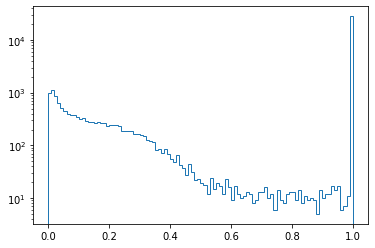

In [102]:
hist.plot(log=True)